# Using GMM Classifier

In [229]:
import numpy as np 
from sklearn.mixture import GaussianMixture as GMM
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import os
import matplotlib.pyplot as plt

In [230]:
%matplotlib notebook

In [231]:
SEED = 19971124

## Load data and split to train and test

In [232]:
dataset = np.loadtxt("Skin_NonSkin.txt")
print(dataset.shape)
print(dataset[101,:])

(245057, 4)
[211. 219. 255.   1.]


In [233]:
skins = dataset[dataset[:,-1] == 1]
nonskins = dataset[dataset[:,-1] == 2]
n_skins = skins.shape[0]
n_nonskins = nonskins.shape[0]
n_total = n_skins + n_nonskins

print(f"skins:{skins.shape}, nonskins:{nonskins.shape}")

skins:(50859, 4), nonskins:(194198, 4)


#### Organize data into skin and non-skin, and split into train and test

In [234]:
skin_pixels = skins[:, :3]
nonskin_pixels = nonskins[:, :3]
skin_train, skin_test = train_test_split(skin_pixels, random_state = SEED)
skin_train_y = np.ones(skin_train.shape[0])
skin_test_y = np.ones(skin_test.shape[0])

nonskin_train, nonskin_test = train_test_split(nonskin_pixels, random_state=SEED)
nonskin_train_y = np.zeros(nonskin_train.shape[0])
nonskin_test_y = np.zeros(nonskin_test.shape[0])

print(f"Skins- Train:{skin_train.shape}, Test:{skin_test.shape}")
print(f"Non-Skins- Train:{nonskin_train.shape}, Test:{nonskin_test.shape}")

Skins- Train:(38144, 3), Test:(12715, 3)
Non-Skins- Train:(145648, 3), Test:(48550, 3)


#### Combine skin and nonskin for both train and test and random shuffle

In [235]:
X_train = np.concatenate((skin_train, nonskin_train), axis=0)
y_train = np.concatenate((skin_train_y, nonskin_train_y), axis=0)
print(f"X_train:{X_train.shape}, y_train:{y_train.shape}")

X_test = np.concatenate((skin_test, nonskin_test), axis=0)
y_test = np.concatenate((skin_test_y, nonskin_test_y), axis=0)
print(f"X_test:{X_test.shape}, y_test:{y_test.shape}")

X_train:(183792, 3), y_train:(183792,)
X_test:(61265, 3), y_test:(61265,)


In [236]:
X_train_shuffled, y_train_shuffled = shuffle(X_train, y_train, random_state = SEED)
X_test_shuffled, y_test_shuffled = shuffle(X_test, y_test, random_state = SEED)

## Train GMM

In [237]:
skin_gmm = GMM(n_components=20, covariance_type='full', tol=1e-5, random_state=SEED, max_iter=1000)
skin_gmm.fit(skin_train)
nonskin_gmm = GMM(n_components=20, covariance_type='full', tol=1e-5, random_state=SEED,  max_iter=1000)
nonskin_gmm.fit(nonskin_train)
print(skin_gmm.converged_, nonskin_gmm.converged_)

True True


### Test GMM

In [238]:
p_skin  = n_skins/n_total
p_nonskin  = n_nonskins/n_total
print(f"P(skin)={p_skin}, P(non-skin)={p_nonskin}")

skin_results = skin_gmm.score_samples(X_train_shuffled)
nonskin_results = nonskin_gmm.score_samples(X_train_shuffled)
results_total = np.concatenate([p_nonskin*nonskin_results[:, np.newaxis], p_skin*skin_results[:, np.newaxis]], axis=1)
results_total.shape
# for i in range(5,15):
#     print("skin", np.exp(skin_results[i]), y_train_shuffled[i])
#     print("nonskin", np.exp(nonskin_results[i]), y_train_shuffled[i])
#     print("after", np.exp(results_total[i]), y_train_shuffled[i])
#     print("#################################")

acc_train = np.sum(np.argmax(results_total, axis=-1) == y_train_shuffled)/y_train_shuffled.shape[0]
print(acc_train)

skin_results_test = skin_gmm.score_samples(X_test_shuffled)
nonskin_results_test = nonskin_gmm.score_samples(X_test_shuffled)
results_total_test = np.concatenate([p_nonskin*nonskin_results_test[:, np.newaxis], p_skin*skin_results_test[:, np.newaxis]], axis=1)
results_total_test.shape

acc_test = np.sum(np.argmax(results_total_test, axis=-1) == y_test_shuffled)/y_test_shuffled.shape[0]
print(acc_test)


P(skin)=0.20753947040892526, P(non-skin)=0.7924605295910747
0.9403564899451554
0.939573981881988


### Testing on face

In [254]:
im = plt.imread('faces/face6.jpg')

In [255]:
im.shape

(1583, 1289, 3)

In [256]:
R = im[:,:,0].flatten()
G = im[:,:,1].flatten()
B = im[:,:,2].flatten()

data  = np.vstack([B,G,R])
data = np.transpose(data)
data.shape

(2040487, 3)

In [257]:
skin = skin_gmm.score_samples(data)
nonskin = nonskin_gmm.score_samples(data)
segmented = np.concatenate([p_nonskin*nonskin[:, np.newaxis], p_skin*skin[:, np.newaxis]], axis=1)
segmented.shape

(2040487, 2)

<IPython.core.display.Javascript object>


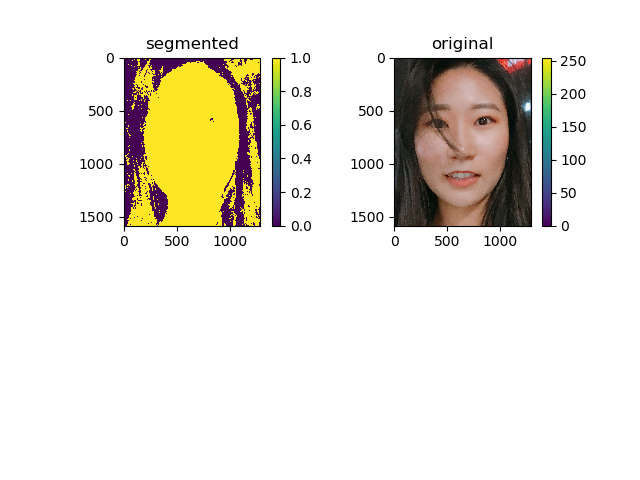

In [258]:
segged = np.argmax(segmented, axis=-1)
segged_img = segged.reshape(im.shape[0], im.shape[1])
                   

fig = plt.figure()
plt.subplot(221)
plt.title("segmented")
plt.imshow(segged_img)
plt.colorbar()
plt.subplot(222)
plt.title("original")
plt.imshow(im)
plt.colorbar()